In [10]:
import yfinance as yf
import pandas as pd
import mplfinance as fplt
import talib # pip install TA-Lib # or via conda install -c conda-forge ta-lib

print("TA-Lib Version : {}".format(talib.__version__))
print("MPLFinance Version : {}".format(fplt.__version__))

TA-Lib Version : 0.4.19
MPLFinance Version : 0.12.10b0


In [11]:
# Example usage
symbols = {
            "AMD": (20, "$"),
            "ABEA.DE": (42, "€"),
            "AMZN": (75, "€"),
            #"ARM": (30, "$"),
            "ASML": (10, "$"),
            #"BSI.MU": (51, "€"),
            "BTC-USD": (0.025, "$"),
            "CRM": (7, "$"),
            #"DDOG": (7, "$"),
            "ETH-USD": (0.493, "$"),
            "KLAC": (3, "$"),
            #"MDB": (5, "$"),
            "META": (15, "$"),
            #"MSFT": (6, "$"),
            "NVDA": (13, "$"),
            #"ISRG": (3, "$"),
            "QCOM": (20, "$"),
            #"RDC.DE": (10, "€"),
            #"RHM.DE": (5, "€"),
            #"SAAB-B.ST": (19, "SEK"),
            #"SHL.DE": (19, "€"),
            #"SMCI": (6, "$"),
            "TSFA.F": (17, "$"),
            "DTE.DE": (0, "€"),
            "^GSPC": (0, "$"),
           }
df = yf.download(list(symbols.keys()), period="200d")

[*********************100%%**********************]  14 of 14 completed


In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sek_factor = yf.download("SEK=X", period="1d", progress=False).iloc[-1]["Adj Close"]
euro_factor = yf.download("EURUSD=X", period="1d", progress=False).iloc[-1]["Adj Close"]

for symbol in symbols:
    df["SMA50", symbol] = df["Adj Close", symbol].rolling(50).mean()
    df["SMA200", symbol] = df["Adj Close", symbol].rolling(200).mean()
    # df["RSI", symbol] = talib.RSI(df["Adj Close", symbol], timeperiod=3)
    df["EMA", symbol] = df["Adj Close", symbol].ewm(span=50, adjust=False).mean()
    df["Adj Daily Return", symbol] = df["Adj Close", symbol].pct_change()
    df["Cum Adj Daily Return", symbol] = df["Adj Daily Return", symbol].cumsum()

In [13]:
round(df["Adj Daily Return"].iloc[-5:] * 100, 2)

Ticker,AMD,ABEA.DE,AMZN,ASML,BTC-USD,CRM,ETH-USD,KLAC,META,NVDA,QCOM,TSFA.F,DTE.DE,^GSPC
Date,,,,,,,,,,,,,,
2024-05-25,0.00,0.00,0.00,0.00,1.08,0.0,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2024-05-26,0.00,0.00,0.00,0.00,-1.08,0.0,2.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2024-05-27,0.00,0.60,0.00,0.00,1.28,0.0,1.73,0.00,0.00,0.00,0.00,2.59,0.00,0.00
2024-05-28,3.16,-0.14,0.77,3.73,0.00,-0.9,0.00,0.91,0.36,6.98,1.29,-3.45,-0.18,0.02
2024-05-29,0.00,0.00,0.00,0.00,-1.11,0.0,-0.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [14]:
total_portfolio_value = 0
for day in df.index:
    if not day.weekday() < 5:
        continue
    total_portfolio_value = 0
    for ticker, (amount_shares, currency) in symbols.items():
        last_price = df["Adj Close", ticker].loc[day]
        if pd.isna(last_price):
            last_price = 0
        if currency == "€":
            last_price /= euro_factor
        if currency == "SEK":
            last_price /= sek_factor
        # print(ticker, " $ value: ", round(amount_shares * last_price))
        # print(ticker, "€:", amount_shares * last_price / euro_factor)
        total_portfolio_value += amount_shares * last_price 
        df.loc[day, "Total Portfolio Value"] = total_portfolio_value
    #print("Total $: ", total_portfolio_value)

print("avg7: ", df["Total Portfolio Value"][-8:-1].mean())
df["Total Portfolio Value"][-8:-1]


avg7:  55245.558395727945


Date
2024-05-22    65220.475616
2024-05-23    66156.553548
2024-05-24    67144.102413
2024-05-25             NaN
2024-05-26             NaN
2024-05-27    12500.083403
2024-05-28    65206.576999
Name: Total Portfolio Value, dtype: float64

In [15]:
df = df[df["Total Portfolio Value"] > 30000]

<Axes: xlabel='Date'>

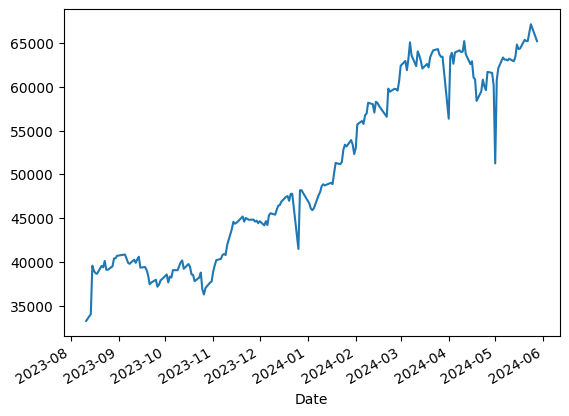

In [16]:
df["Total Portfolio Value"].plot()

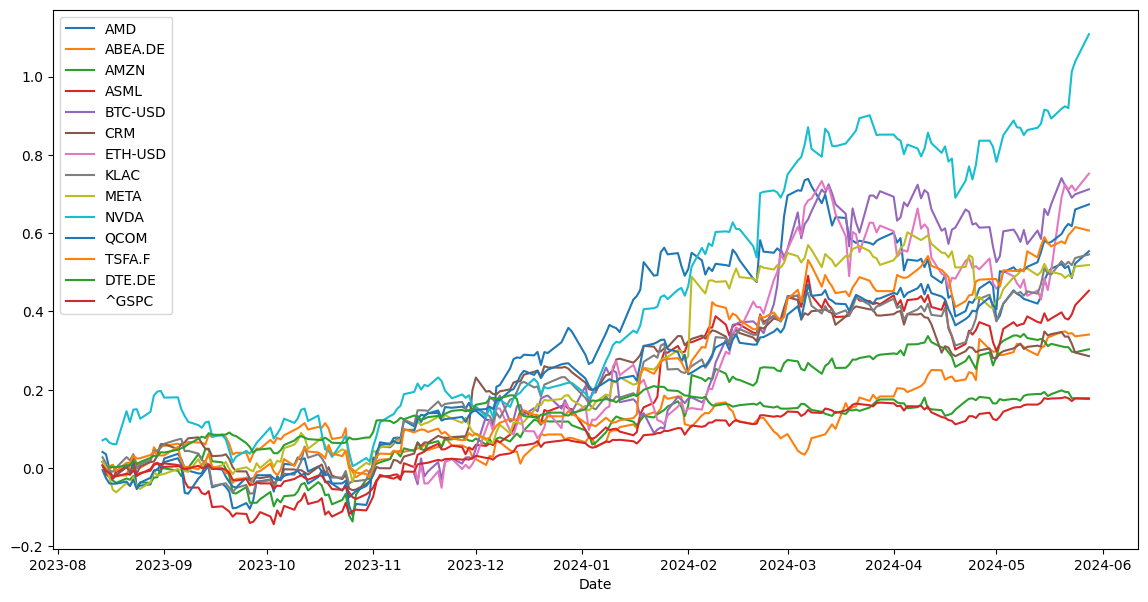

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14,7))
plt.plot(df['Cum Adj Daily Return'])
plt.xlabel('Date')
plt.legend(symbols)
plt.show()

In [18]:
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta

i=8
# Calculate the date i weeks ago
ago = datetime.today() - timedelta(days=i*7)
# Convert the date to a string in the desired format
date_string = ago.strftime("%Y-%m-%d")
tmp = df[df.index >= date_string].copy()

for symbol in symbols:
    tmp["Cum Adj Daily Return", symbol] = (tmp["Adj Daily Return", symbol] - tmp["Adj Daily Return", "^GSPC"]).cumsum()

# Create a scatter plot
fig = px.line(tmp['Cum Adj Daily Return'], title=f"week {i}")
# Show the plot
fig.show()
